In [ ]:
!wget -qO- https://drive.google.com/uc?id=1DqCG_PqSsfpVu6vEkIXcOea9QnTYsdle > faithful.csv

# Đề bài

Cho bộ dữ liệu **Faithful**, sử dụng phương pháp tối đa hóa kì vọng (Expectation-Maximization) cho cột `waiting` của bộ dữ liệu. Sau khi train xong thì ta có các tham số của mô hình. Hỏi với các tham số này thì model đã tốt chưa, sử dụng Kolmogorov-Smirnov (K-S test) để trả lời câu hỏi này. Tìm khoảng chênh lệch tối đa (maximum discrepancy) giữa cdf thực nghiệm (empirical cdf) và cdf (fitted mixture cdf).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture

In [ ]:
df = pd.read_csv("faithful.csv", index_col="Unnamed: 0")

In [ ]:
df.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


Tập dữ liệu chứa thông tin chi tiết về thời gian phun nước và thời gian chờ đợi giữa các lần phun của mạch phun nước Old Faithful

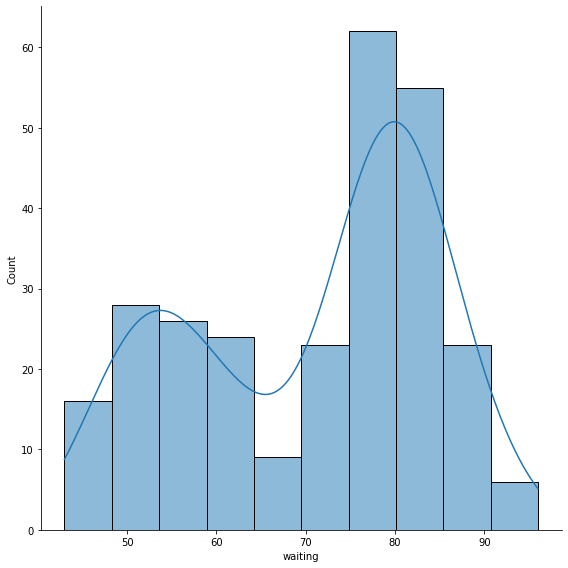

In [ ]:
sns.displot(data=df, x="waiting", kde=True, height=8);

Ta thấy dữ liệu có phân phối mixed Gaussian với 2 thành phần.

## Empirical cdf

$F_X = \dfrac{M(t)}{n}$, trong đó $M(t)$ là số lượng $X_i≤t$.

In [ ]:
def ECDF(x):
  sq = x.value_counts()
  return sq.sort_index().cumsum()/len(df)

ecdf = ECDF(df.waiting)

## Fitted mixture cdf

In [ ]:
lambda_ = np.array([0.5, 0.5])
mu_ =  np.array([55, 80])
sigma_ = np.array([10, 10])

gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
gmm.weights_ = lambda_
gmm.means_ = mu_
gmm.covariances_ = sigma_ ** 2

X = np.array(df.waiting).reshape(-1,1)
gmm.fit(X)
print(f"weight: {gmm.weights_}\nmean: {gmm.means_.reshape(-1,)}\nvariance: {np.sqrt(gmm.covariances_)}")

weight: [0.36345767 0.63654233]
mean: [54.69984271 80.14546556]
variance: [5.94286542 5.81293521]


CDF của phân phối mixed Gaussian với CDF của mỗi thành phần là $F_1,F_2,F_3...$, và trọng số là $w_1,w_2,w_3...$ thì ta có:

$F_{mixed} = \sum_{i=1}^{n} w_i*F_i$

In [ ]:
def bimodal_cdf(x, mean, std, pmix): 
  return pmix[0] * stats.norm.cdf(x,mean[0],std[0]) + pmix[1] * stats.norm.cdf(x,mean[1],std[1])

In [ ]:
fitted_mixture_cdf = bimodal_cdf(np.unique(X),gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)
fitted_mixture_cdf = fitted_mixture_cdf.reshape(-1,)

## Visualize

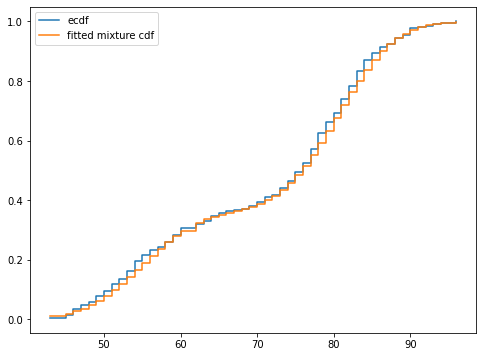

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ecdf.index, ecdf.values, drawstyle='steps-post', label="ecdf")
plt.plot(ecdf.index, fitted_mixture_cdf, drawstyle='steps-post', label="fitted mixture cdf")
plt.legend(loc="upper left")
plt.show()

Bằng trực quan thì ta thấy 2 mẫu có phân phối gần giống nhau.

## The maximum discrepancy

Giả thuyết $H_0$: Hai mẫu có cùng phân phối

In [ ]:
result = stats.ks_2samp(ecdf, fitted_mixture_cdf)

In [ ]:
print(f"Maximum discrepancy: {result[0]}\np_value: {result[1]}")

Maximum discrepancy: 0.0392156862745098
p_value: 0.9999999999999943


Ta thấy p_value xấp xỉ 1 nên không bác bỏ giả thuyết phân phối của hai mẫu là như nhau.